<ipython-input-1-4aeba9b46a59>:80: RuntimeWarning: invalid value encountered in sqrt
  coefficients = [a0 / 2] + [np.sqrt(a*2 + b*2) for a, b in zip(an, bn)]


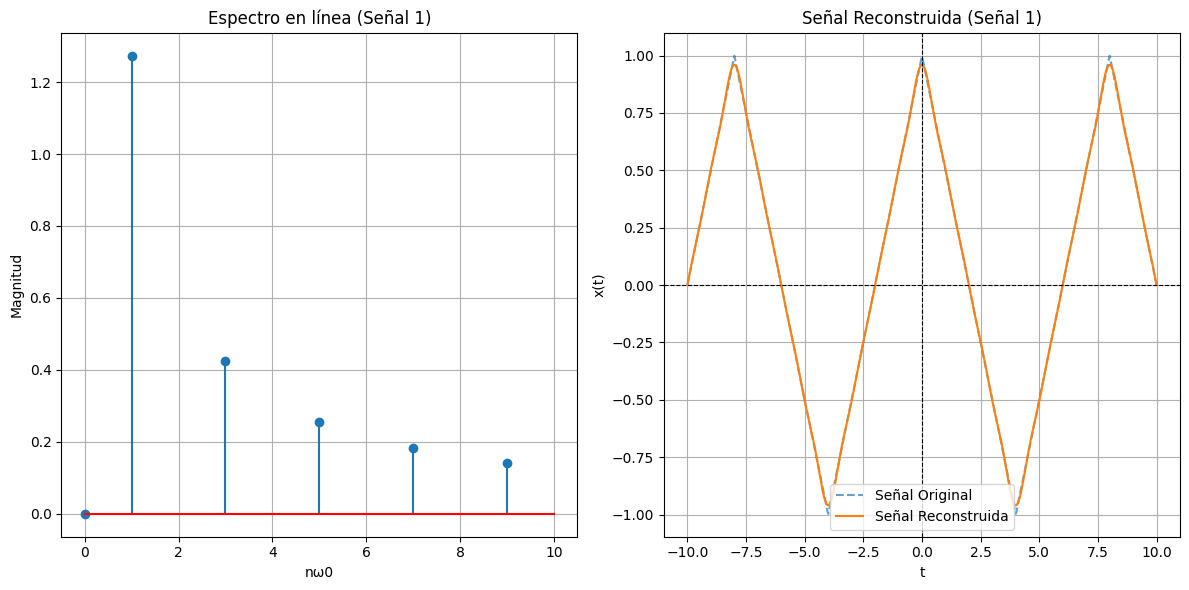

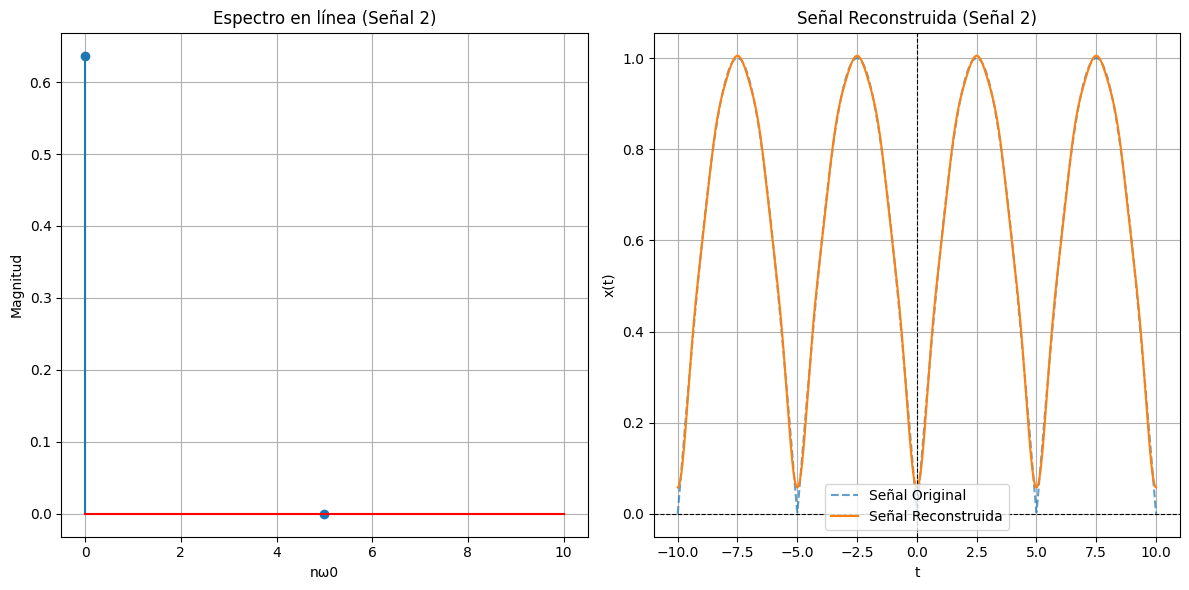

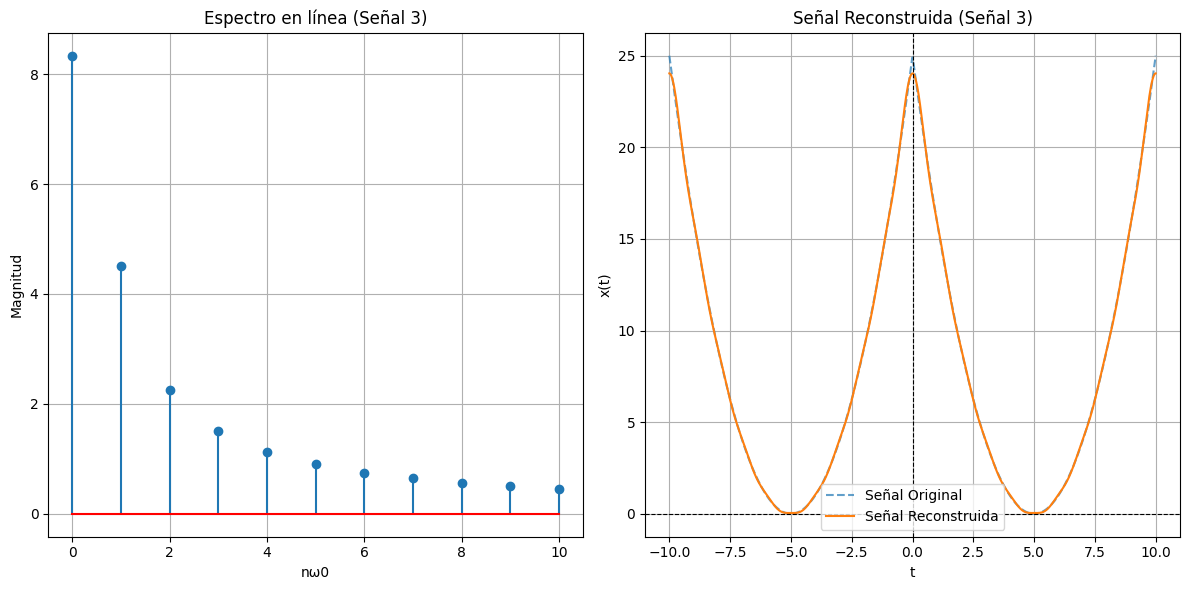

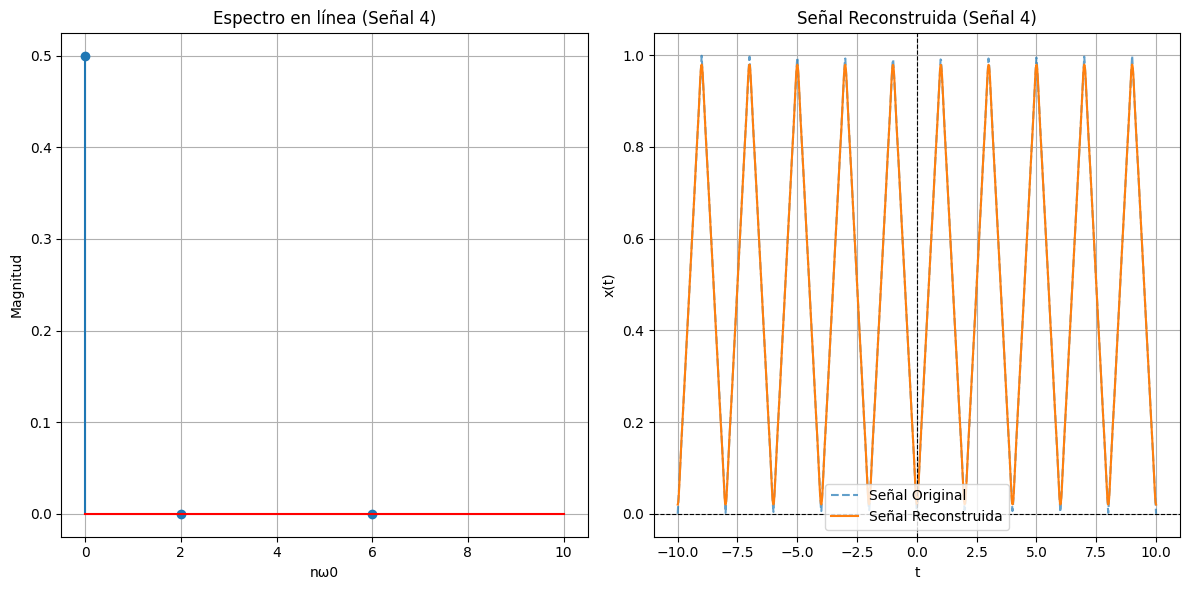

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

# Definición de las señales periódicas
def signal_1(t, T=8):
    """Triangular"""
    t = t % T
    if 0 <= t < T/2:
        return 1 - (4 * t / T)
    elif T/2 <= t < T:
        return -1 + (4 * (t - T/2) / T)
    return 0

def signal_2(t, T=10):
    """Abs(Seno)"""
    t = t % T
    return np.abs(np.sin(2 * np.pi * t / T))

def signal_3(t, T=10):
    """Parabólica"""
    t = t % T - T/2
    return t**2

def signal_4(t, T=2):
    """Lineal segmentada"""
    t = t % T
    if 0 <= t < T/2:
        return 2 * t / T
    elif T/2 <= t < T:
        return 2 - (2 * t / T)
    return 0

# Diccionario para mapear las señales a sus definiciones
signals = {
    "Señal 1": signal_1,
    "Señal 2": signal_2,
    "Señal 3": signal_3,
    "Señal 4": signal_4
}

# Cálculo de los coeficientes de Fourier
def calculate_fourier_coefficients(signal, T, N=10):
    """Calcula los coeficientes de Fourier hasta N armónicos."""
    a0 = (2 / T) * quad(lambda t: signal(t, T), 0, T)[0]
    an = []
    bn = []

    for n in range(1, N + 1):
        an.append((2 / T) * quad(lambda t: signal(t, T) * np.cos(2 * np.pi * n * t / T), 0, T)[0])
        bn.append((2 / T) * quad(lambda t: signal(t, T) * np.sin(2 * np.pi * n * t / T), 0, T)[0])

    return a0, an, bn

# Reconstrucción de la señal
def reconstruct_signal(a0, an, bn, T, t):
    """Reconstruye la señal a partir de sus coeficientes de Fourier."""
    reconstruction = a0 / 2
    for n in range(1, len(an) + 1):
        reconstruction += an[n-1] * np.cos(2 * np.pi * n * t / T) + bn[n-1] * np.sin(2 * np.pi * n * t / T)
    return reconstruction

# Parámetros generales
N = 10  # Número de armónicos
t = np.linspace(-10, 10, 1000)  # Intervalo de tiempo amplio para graficar 2 periodos

# Generación de gráficos para cada señal
for signal_name, signal_function in signals.items():
    T = 8 if signal_name == "Señal 1" else (10 if signal_name in ["Señal 2", "Señal 3"] else 2)

    # Cálculo de coeficientes
    a0, an, bn = calculate_fourier_coefficients(signal_function, T, N)

    # Reconstrucción de la señal
    reconstructed_signal = reconstruct_signal(a0, an, bn, T, t)

    # Espectro en línea
    plt.figure(figsize=(12, 6))
    n_values = np.arange(0, N + 1)
    coefficients = [a0 / 2] + [np.sqrt(a*2 + b*2) for a, b in zip(an, bn)]

    plt.subplot(1, 2, 1)
    plt.stem(n_values, coefficients, basefmt="r-")
    plt.title(f"Espectro en línea ({signal_name})")
    plt.xlabel("nω0")
    plt.ylabel("Magnitud")
    plt.grid()

    # Señal reconstruida
    plt.subplot(1, 2, 2)
    plt.plot(t, [signal_function(tt, T) for tt in t], label="Señal Original", linestyle="--", alpha=0.7)
    plt.plot(t, reconstructed_signal, label="Señal Reconstruida")
    plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
    plt.axvline(0, color="black", linestyle="--", linewidth=0.8)
    plt.title(f"Señal Reconstruida ({signal_name})")
    plt.xlabel("t")
    plt.ylabel("x(t)")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

punto 3

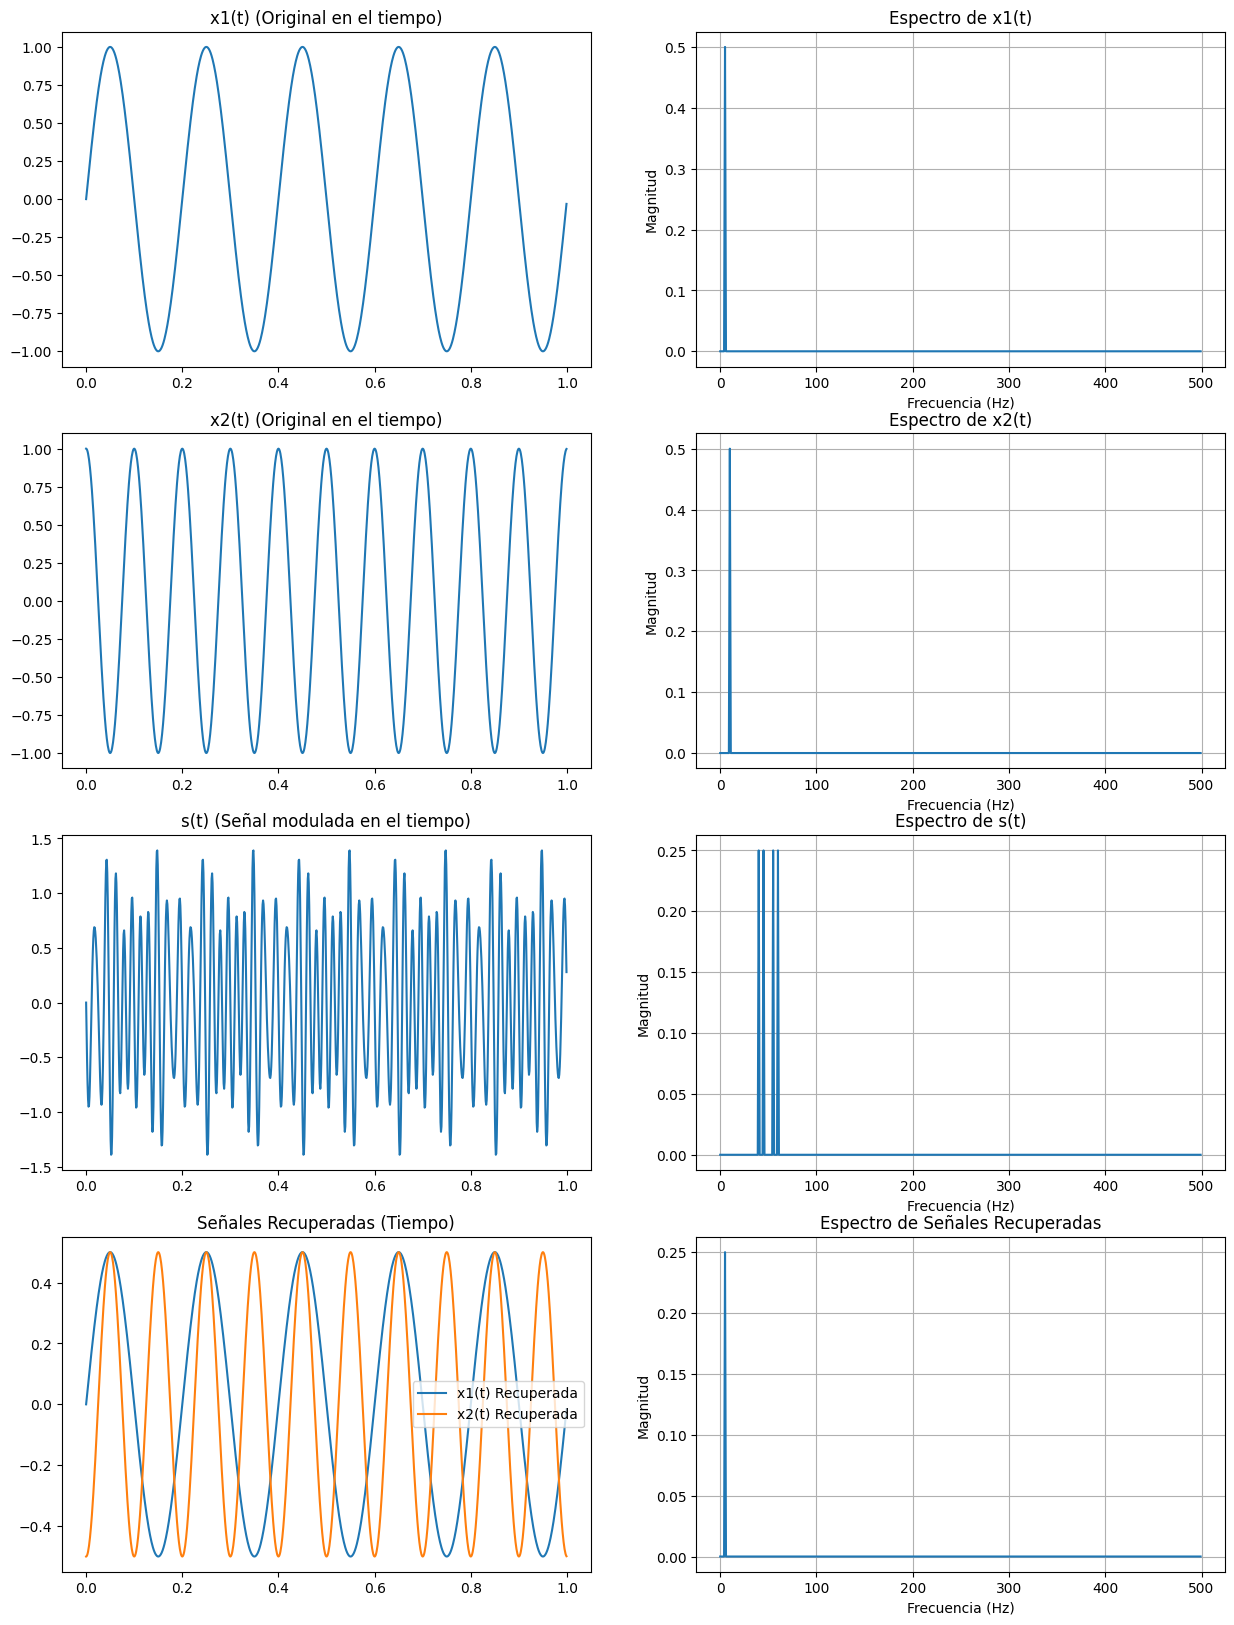

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import butter, lfilter

# Parámetros de la simulación
fs = 1000  # Frecuencia de muestreo (Hz)
t = np.arange(0, 1, 1/fs)  # Vector de tiempo (1 segundo)
f_c = 50  # Frecuencia de la portadora (Hz)
w_c = 2 * np.pi * f_c  # Frecuencia angular de la portadora

# Señales moduladoras
f_x1 = 5  # Frecuencia de x1(t) (Hz)
f_x2 = 10  # Frecuencia de x2(t) (Hz)
x1 = np.sin(2 * np.pi * f_x1 * t)  # Señal x1(t)
x2 = np.cos(2 * np.pi * f_x2 * t)  # Señal x2(t)

# Portadoras en cuadratura
cos_carrier = np.cos(w_c * t)
sin_carrier = np.sin(w_c * t)

# Modulación
s = x1 * cos_carrier - x2 * sin_carrier

# Demodulación (detección sincrónica)
r1 = s * cos_carrier  # Recuperación de x1
r2 = s * sin_carrier  # Recuperación de x2

# Filtro pasa bajas ideal
def ideal_lowpass_filter(signal, cutoff_freq, fs):
    # Transformada de Fourier
    fft_signal = fft(signal)
    freqs = fftfreq(len(signal), 1/fs)

    # Crear máscara para frecuencias por debajo de la frecuencia de corte
    mask = np.abs(freqs) <= cutoff_freq
    filtered_fft = fft_signal * mask

    # Transformada inversa para regresar al dominio del tiempo
    return np.real(np.fft.ifft(filtered_fft))

cutoff = 20  # Frecuencia de corte del filtro pasa-bajas (Hz)
x1_rec = ideal_lowpass_filter(r1, cutoff, fs)
x2_rec = ideal_lowpass_filter(r2, cutoff, fs)

# Función para graficar espectros
def plot_spectrum(signal, fs, title):
    N = len(signal)
    freqs = fftfreq(N, 1/fs)
    spectrum = np.abs(fft(signal)) / N  # Densidad espectral de potencia normalizada
    plt.plot(freqs[:N//2], spectrum[:N//2])  # Solo frecuencias positivas
    plt.title(title)
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('Magnitud')
    plt.grid()

# Gráficas
plt.figure(figsize=(15, 20))

# Señales en el tiempo
plt.subplot(4, 2, 1)
plt.plot(t, x1)
plt.title("x1(t) (Original en el tiempo)")

plt.subplot(4, 2, 2)
plot_spectrum(x1, fs, "Espectro de x1(t)")

plt.subplot(4, 2, 3)
plt.plot(t, x2)
plt.title("x2(t) (Original en el tiempo)")

plt.subplot(4, 2, 4)
plot_spectrum(x2, fs, "Espectro de x2(t)")

plt.subplot(4, 2, 5)
plt.plot(t, s)
plt.title("s(t) (Señal modulada en el tiempo)")

plt.subplot(4, 2, 6)
plot_spectrum(s, fs, "Espectro de s(t)")

plt.subplot(4, 2, 7)
plt.plot(t, x1_rec, label='x1(t) Recuperada')
plt.plot(t, x2_rec, label='x2(t) Recuperada')
plt.legend()
plt.title("Señales Recuperadas (Tiempo)")

plt.subplot(4, 2, 8)
plot_spectrum(x1_rec, fs, "Espectro de Señales Recuperadas")
plt.show()


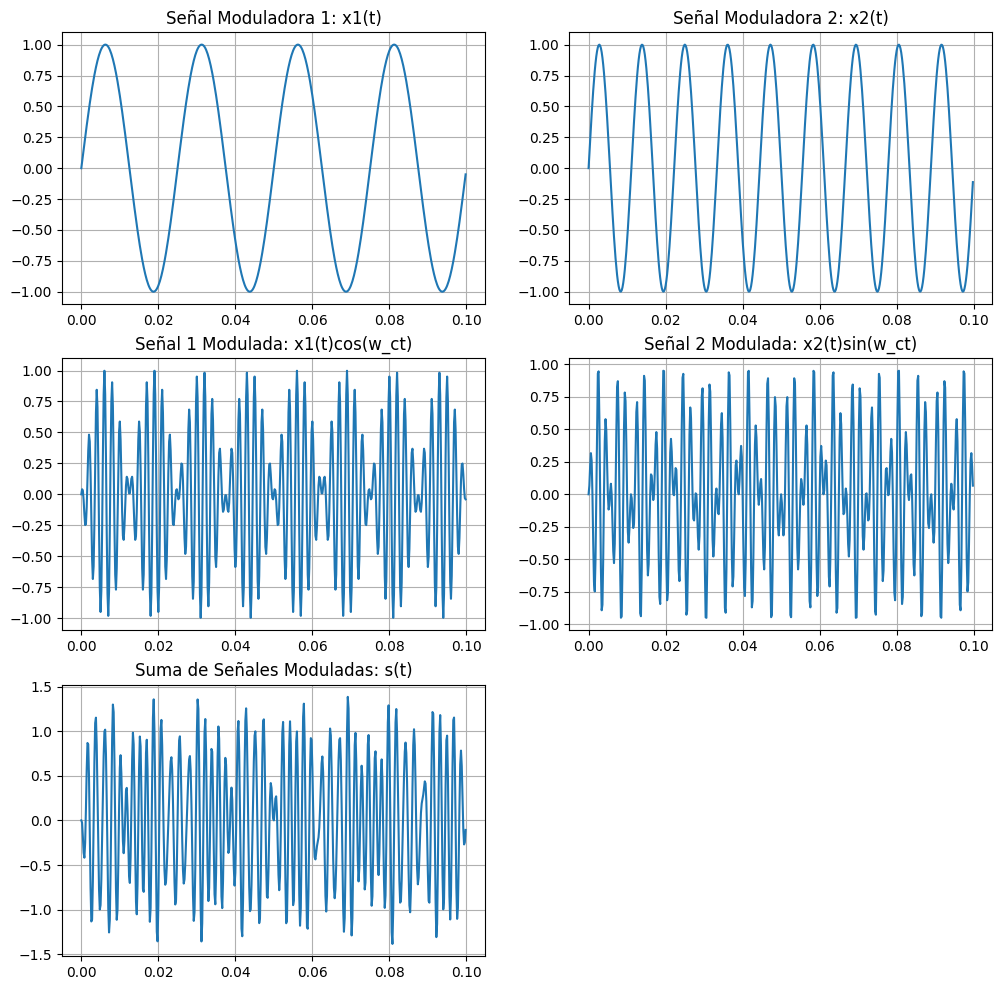

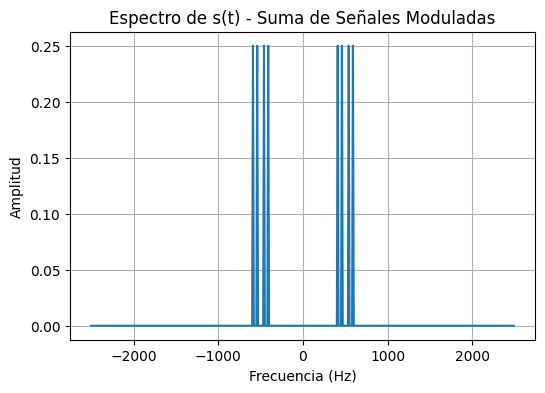

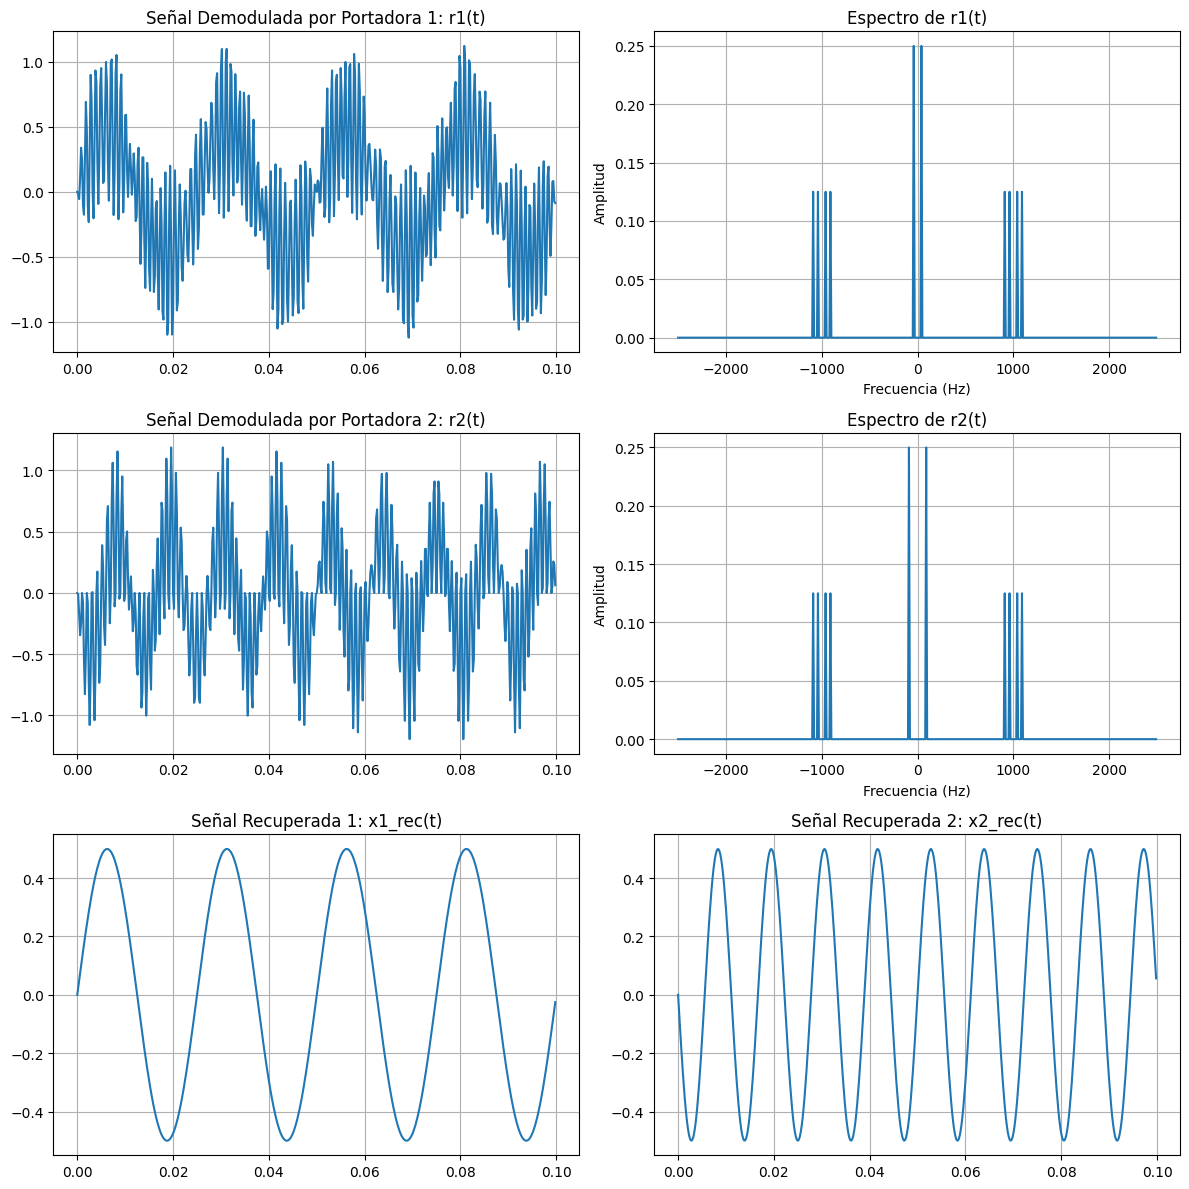

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, fftshift

# Parámetros de la simulación
fs = 5000  # Frecuencia de muestreo (Hz)
T = 0.1    # Duración de la señal (s)
t = np.linspace(0, T, int(fs*T), endpoint=False)  # Vector de tiempo
f_c = 500  # Frecuencia de la portadora (Hz)
w_c = 2 * np.pi * f_c  # Frecuencia angular de la portadora

# Frecuencias de las señales moduladoras
f1 = 40  # Frecuencia de x1(t)
f2 = 90  # Frecuencia de x2(t)

# Señales moduladoras
x1 = np.sin(2 * np.pi * f1 * t)
x2 = np.sin(2 * np.pi * f2 * t)

# Portadoras ortogonales
cos_carrier = np.cos(w_c * t)
sin_carrier = np.sin(w_c * t)

# Modulación
s1 = x1 * cos_carrier  # Señal 1 modulada
s2 = x2 * sin_carrier  # Señal 2 modulada
s = s1 - s2  # Señal combinada transmitida

# Demodulación
r1 = s * cos_carrier  # Multiplicación con cos(ω₀t)
r2 = s * sin_carrier  # Multiplicación con sin(ω₀t)

# Filtro pasa-bajas ideal para recuperar las señales originales
def ideal_lowpass_filter(signal, cutoff, fs):
    N = len(signal)
    freqs = fftfreq(N, 1/fs)
    fft_signal = fft(signal)
    fft_signal[np.abs(freqs) > cutoff] = 0  # Filtrado ideal
    return np.real(np.fft.ifft(fft_signal))

cutoff = 150  # Frecuencia de corte del filtro pasa-bajas (Hz)
x1_rec = ideal_lowpass_filter(r1, cutoff, fs)
x2_rec = ideal_lowpass_filter(r2, cutoff, fs)

# Función para calcular y graficar espectros
def plot_spectrum(signal, fs, title):
    N = len(signal)
    freqs = fftfreq(N, 1/fs)
    spectrum = np.abs(fftshift(fft(signal))) / N
    plt.plot(fftshift(freqs), spectrum)
    plt.title(title)
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('Amplitud')
    plt.grid()

# Gráficas en el dominio del tiempo
plt.figure(figsize=(12, 12))

# Señales moduladoras
plt.subplot(3, 2, 1)
plt.plot(t, x1)
plt.title("Señal Moduladora 1: x1(t)")
plt.grid()

plt.subplot(3, 2, 2)
plt.plot(t, x2)
plt.title("Señal Moduladora 2: x2(t)")
plt.grid()

# Señales moduladas
plt.subplot(3, 2, 3)
plt.plot(t, s1)
plt.title("Señal 1 Modulada: x1(t)cos(w_ct)")
plt.grid()

plt.subplot(3, 2, 4)
plt.plot(t, s2)
plt.title("Señal 2 Modulada: x2(t)sin(w_ct)")
plt.grid()

# Señal combinada
plt.subplot(3, 2, 5)
plt.plot(t, s)
plt.title("Suma de Señales Moduladas: s(t)")
plt.grid()

# Espectro de la señal combinada
plt.figure(figsize=(6, 4))
plot_spectrum(s, fs, "Espectro de s(t) - Suma de Señales Moduladas")
plt.show()

# Señales demoduladas y recuperadas
plt.figure(figsize=(12, 12))
plt.subplot(3, 2, 1)
plt.plot(t, r1)
plt.title("Señal Demodulada por Portadora 1: r1(t)")
plt.grid()

plt.subplot(3, 2, 2)
plot_spectrum(r1, fs, "Espectro de r1(t)")

plt.subplot(3, 2, 3)
plt.plot(t, r2)
plt.title("Señal Demodulada por Portadora 2: r2(t)")
plt.grid()

plt.subplot(3, 2, 4)
plot_spectrum(r2, fs, "Espectro de r2(t)")

# Señales recuperadas
plt.subplot(3, 2, 5)
plt.plot(t, x1_rec)
plt.title("Señal Recuperada 1: x1_rec(t)")
plt.grid()

plt.subplot(3, 2, 6)
plt.plot(t, x2_rec)
plt.title("Señal Recuperada 2: x2_rec(t)")
plt.grid()

plt.tight_layout()
plt.show()


punto 4

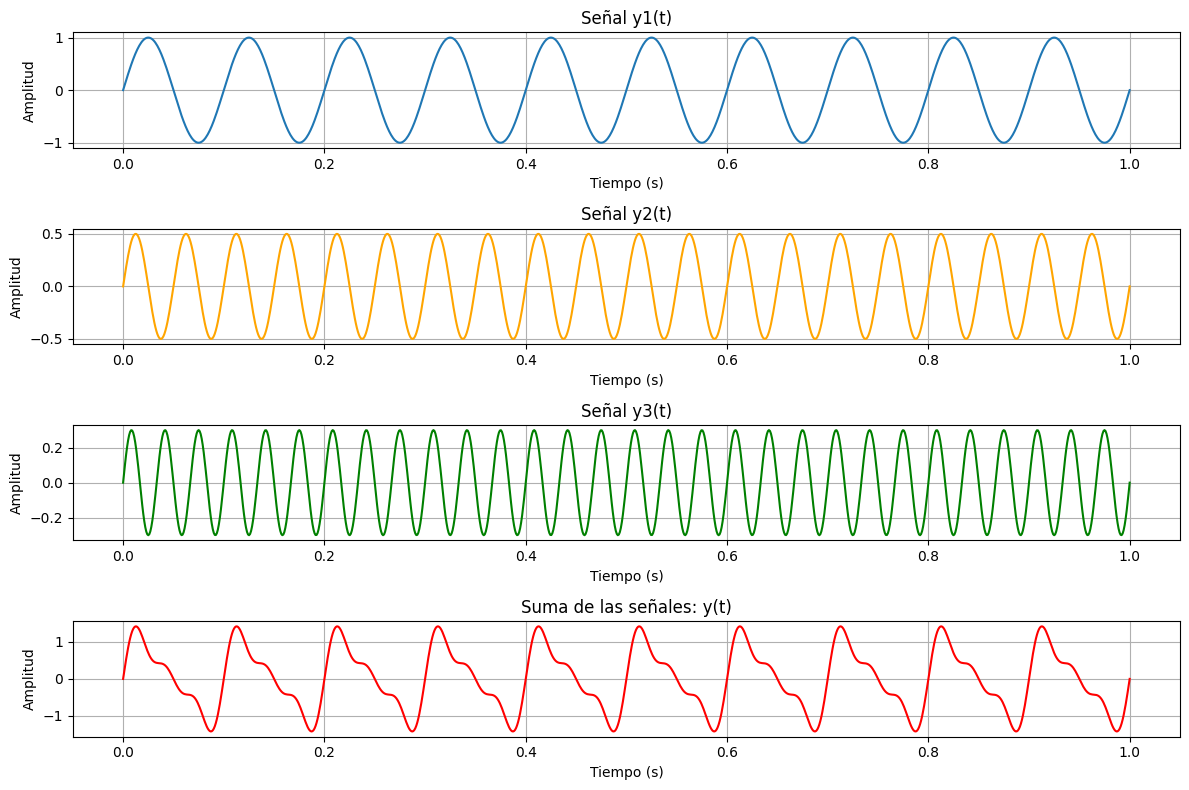

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros para las tres señales sinusoidales
frequencies = [10, 20, 30]  # Frecuencias en Hz
amplitudes = [1, 0.5, 0.3]  # Amplitudes
time = np.linspace(0, 1, 1000)  # 1 segundo de duración

# Generación de las señales sinusoidales
y1 = amplitudes[0] * np.sin(2 * np.pi * frequencies[0] * time)
y2 = amplitudes[1] * np.sin(2 * np.pi * frequencies[1] * time)
y3 = amplitudes[2] * np.sin(2 * np.pi * frequencies[2] * time)

# Suma de las señales
y = y1 + y2 + y3

# Graficar las señales individuales y la suma
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(time, y1, label="y1(t)")
plt.title("Señal y1(t)")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.grid()

plt.subplot(4, 1, 2)
plt.plot(time, y2, label="y2(t)", color="orange")
plt.title("Señal y2(t)")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.grid()

plt.subplot(4, 1, 3)
plt.plot(time, y3, label="y3(t)", color="green")
plt.title("Señal y3(t)")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.grid()

plt.subplot(4, 1, 4)
plt.plot(time, y, label="y(t) = y1(t) + y2(t) + y3(t)", color="red")
plt.title("Suma de las señales: y(t)")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.grid()

plt.tight_layout()
plt.show()

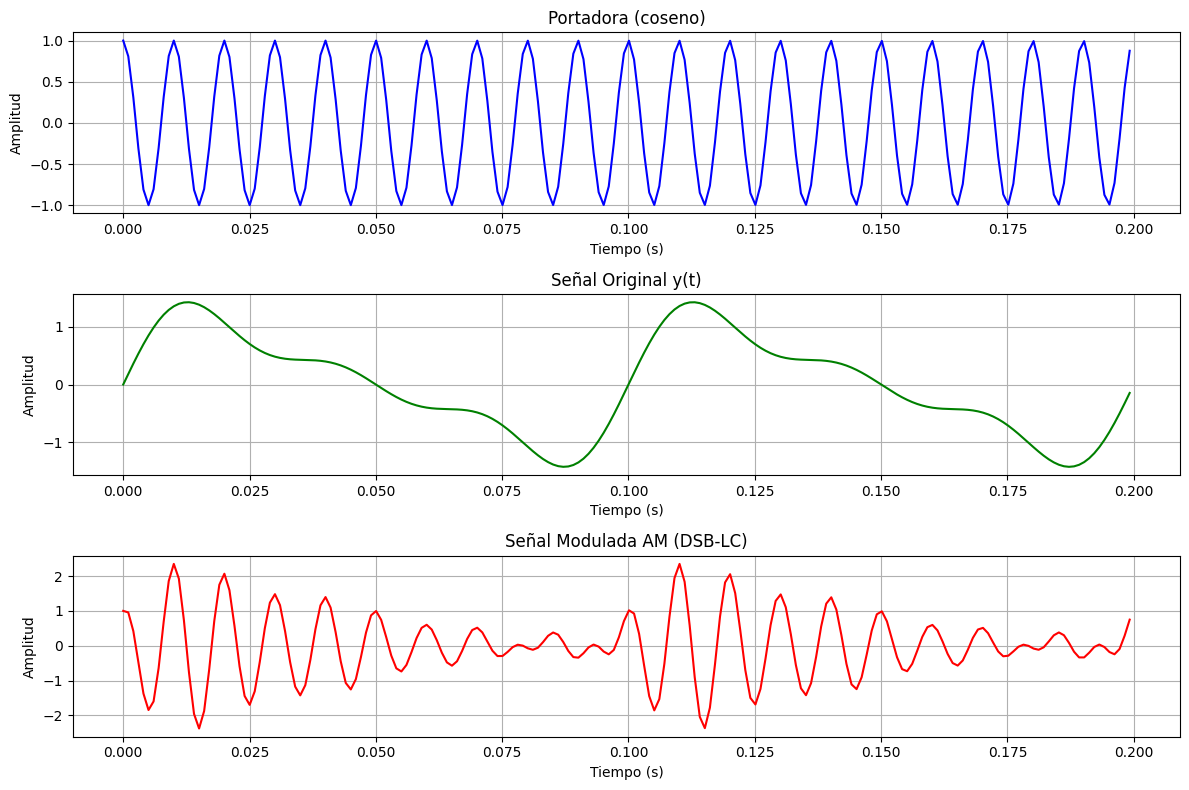

In [ ]:
# Parámetros de la portadora
carrier_frequency = 100  # Frecuencia de la portadora en Hz
carrier_amplitude = 1  # Amplitud de la portadora

# Generar la portadora
carrier = carrier_amplitude * np.cos(2 * np.pi * carrier_frequency * time)

# Señal modulada (AM DSB-LC)
modulated_signal = (1 + y) * carrier

# Graficar la portadora, la señal y la señal modulada
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(time[:200], carrier[:200], label="Portadora", color="blue")
plt.title("Portadora (coseno)")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(time[:200], y[:200], label="Señal Original", color="green")
plt.title("Señal Original y(t)")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(time[:200], modulated_signal[:200], label="Señal Modulada", color="red")
plt.title("Señal Modulada AM (DSB-LC)")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.grid()

plt.tight_layout()
plt.show()

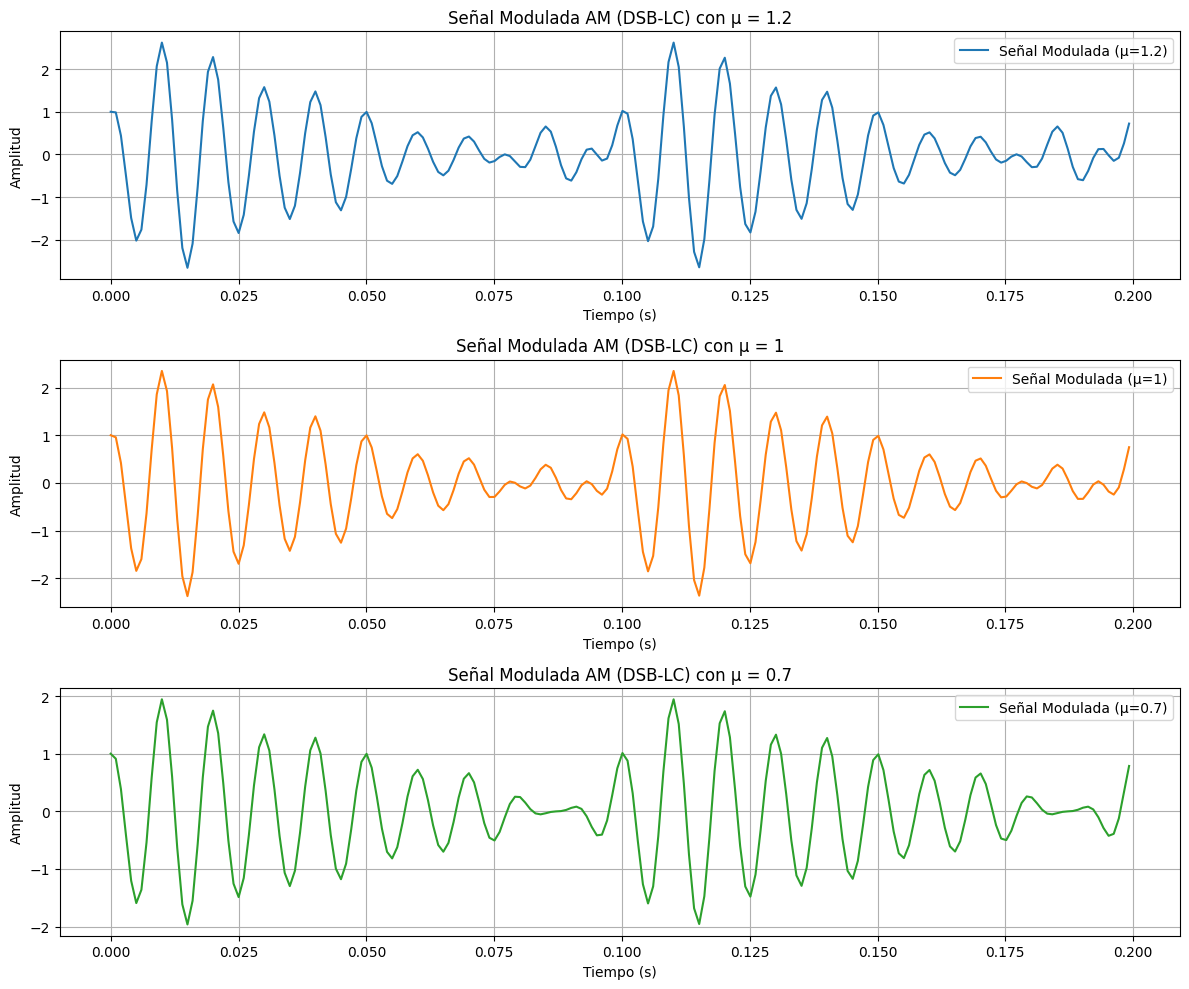

In [ ]:
# Índices de modulación
modulation_indices = [1.2, 1, 0.7]

# Generar y graficar las señales moduladas para cada índice de modulación
plt.figure(figsize=(12, 10))
for i, mu in enumerate(modulation_indices):
    # Señal modulada con índice de modulación mu
    modulated_signal_mu = (1 + mu * y) * carrier

    # Graficar la señal modulada
    plt.subplot(3, 1, i + 1)
    plt.plot(time[:200], modulated_signal_mu[:200], label=f"Señal Modulada (μ={mu})", color="C"+str(i))
    plt.title(f"Señal Modulada AM (DSB-LC) con μ = {mu}")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud")
    plt.grid()
    plt.legend()

plt.tight_layout()
plt.show()

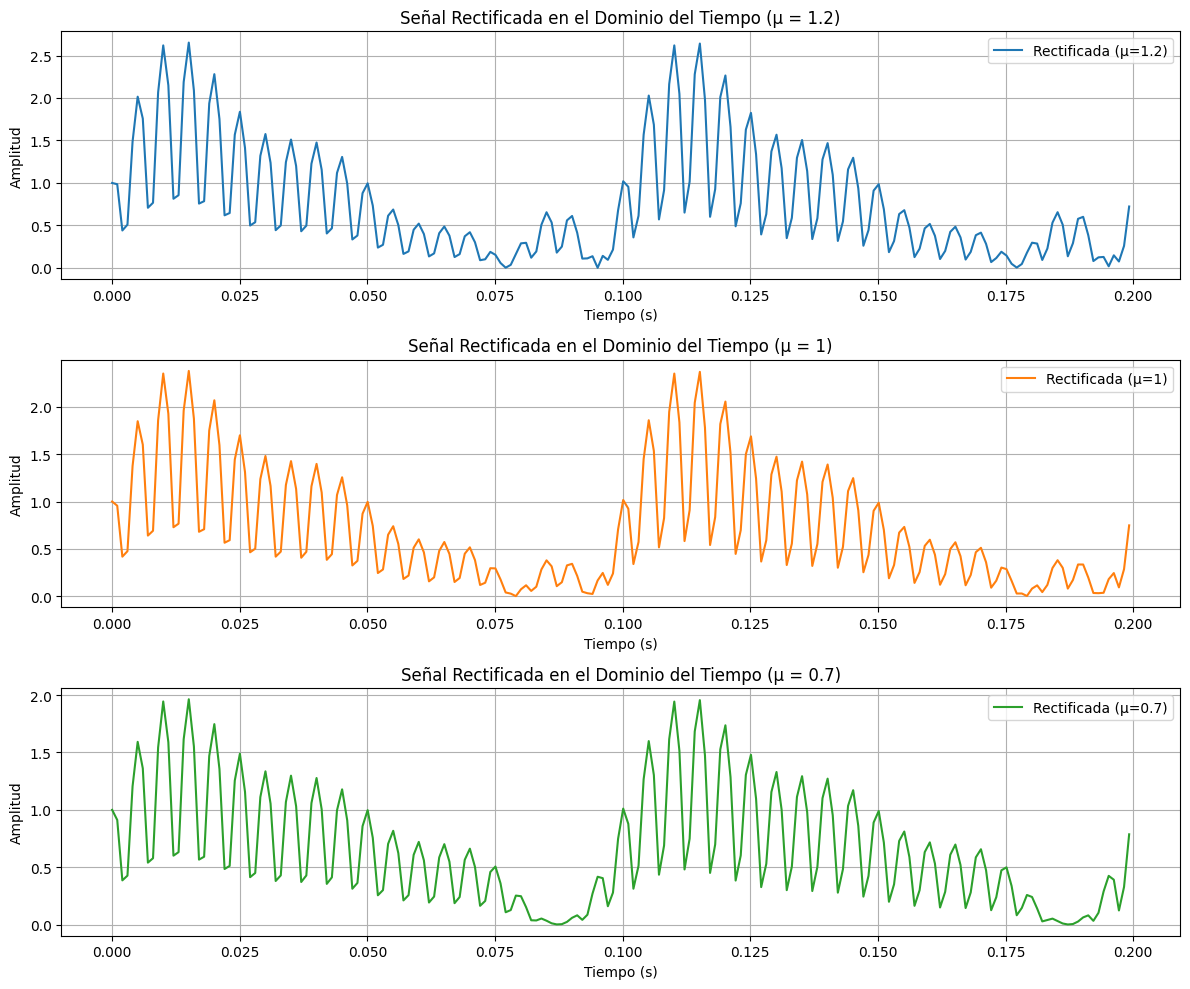

In [ ]:
# Rectificación de las señales moduladas para cada índice de modulación
plt.figure(figsize=(12, 10))

for i, mu in enumerate(modulation_indices):
    # Señal modulada con índice de modulación mu
    modulated_signal_mu = (1 + mu * y) * carrier

    # Señal rectificada
    rectified_signal = np.abs(modulated_signal_mu)

    # Graficar la señal rectificada
    plt.subplot(3, 1, i + 1)
    plt.plot(time[:200], rectified_signal[:200], label=f"Rectificada (μ={mu})", color="C"+str(i))
    plt.title(f"Señal Rectificada en el Dominio del Tiempo (μ = {mu})")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud")
    plt.grid()
    plt.legend()

plt.tight_layout()
plt.show()